#### **This notebook explain with details some concepts that are not trivials with examples. With the purpose that the reader can understand the complete process of training a neuronal network.**

# Goals
* Understand how does an image clasification model work under the hood.
* How does a network improve its parameteres in each epoch.
* Understand how does the mathematic operation used by the model are performed (Convolution, MaxPolling, ...)

Here we are using the following `network`: https://keras.io/examples/vision/image_classification_from_scratch/

# Preliminars

This section introduce you to tensorflow objects (`Dataset`, `Layers`) manipulation.

In [1]:
import tensorflow as tf

2023-11-05 19:49:51.448978: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-05 19:49:51.483874: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 19:49:51.483903: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 19:49:51.483930: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 19:49:51.490353: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-05 19:49:51.491010: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Datasets

#### Resources
* `documentation`: https://www.tensorflow.org/api_docs/python/tf/data/Dataset
* TensorFlow Datasets: https://www.tensorflow.org/datasets/overview

In [2]:
#help(tf.data.Dataset)

In [3]:
ds = tf.data.Dataset.range(6)

2023-11-05 19:49:53.291807: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-11-05 19:49:53.291900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: bell
2023-11-05 19:49:53.292172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: bell
2023-11-05 19:49:53.292397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 545.29.2
2023-11-05 19:49:53.292489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.113.1
2023-11-05 19:49:53.292517: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 535.113.1 does not match DSO version 545.29.2 -- cannot find working devices in this configuration


In [4]:
# number of elements
tf.data.experimental.cardinality(ds)

<tf.Tensor: shape=(), dtype=int64, numpy=6>

In [5]:
list(ds.as_numpy_iterator())

[0, 1, 2, 3, 4, 5]

In [6]:
# create batches of 3 elements
batches = ds.batch(3)

In [7]:
# number of batches (DATASET_SIZE / BATCH_SIZE)
tf.data.experimental.cardinality(batches)

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [8]:
list(batches.as_numpy_iterator())

[array([0, 1, 2]), array([3, 4, 5])]

### Get a sub dataset of a dataset

In [9]:
# How to get a subset from BatchDataSet or PrefetchDataset in Tensorflow?
# - https://stackoverflow.com/questions/68078664/how-to-get-a-subset-from-batchdataset-or-prefetchdataset-in-tensorflow

large_ds = tf.data.Dataset.range(1000)

In [10]:
# select 100 elements
subset = large_ds.take(100)
print(f"type(subset): {type(subset)}")
print(f"subset is Dataset: {issubclass(tf.data.Dataset, type(subset))}")

x = list(subset.as_numpy_iterator())
len(x)

type(subset): <class 'tensorflow.python.data.ops.take_op._TakeDataset'>
subset is Dataset: False


100

In [11]:
batched_ds = large_ds.batch(10)

In [12]:
# select 10 batches (batch_size = 10)
y = batched_ds.take(10)

yy = list(subset.as_numpy_iterator())
len(yy)

100

# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2022/11/10<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

## Setup

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [14]:
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [15]:
#!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf		   kagglecatsanddogs_5340.zip
 checkpoints				   logs
 image_classification_from_scratch.ipynb   PetImages
 images					  'readme[1].txt'


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.

In [16]:
!ls PetImages

Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.

In [17]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            # Image identifier
            # - https://en.wikipedia.org/wiki/JPEG_File_Interchange_Format
            #
            # peek function - python
            # - https://docs.python.org/3/library/io.html#io.BufferedReader.peek

            # validate if the image contains the b'JFIF' signature (which validate that is an image)
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


## Generate a `Dataset`

In [18]:
image_size = (180, 180)
batch_size = 128

# image_dataset_from_directory documentation:
# - https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
#
# Read images from directory
#  main_directory/
#  ...class_a/ 1
#  ......a_image_1.jpg
#  ......a_image_2.jpg
#  ...class_b/ 0
#  ......b_image_1.jpg
#  ......b_image_2.jpg

# dataset = [(a_image_1, 1), ....] 1000 -> TRAIN [800](80 %), VAL[200] (20 %) -> TRAIN = [BATCH1, BATCH2, ..., BATCH7] | VAL = [BATCH1, BATCH2]

# BATCH = [(IMG1, LABEL1), (IMG2, LABEL2), ....]

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


In [19]:
# What exactly does prefetch in tensorflow?
# - https://stackoverflow.com/questions/63187238/what-exactly-does-prefetch-in-tensorflow
# - https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [20]:
# 147 batches ~ TRAIN_SIZE / BATCH_SIZE == 18728/128 = 146.3125 (the last batch is not complete)
tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=147>

## Inspecting a batch of images

In [21]:
type(train_ds.take(1))

tensorflow.python.data.ops.take_op._TakeDataset

In [22]:
# take a batch of the train_df Dataset
batch_x, batch_y = list(train_ds.take(1).as_numpy_iterator())[0]

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


In [23]:
# NOTE:
# - Each image has a size of 180x180 with 3 channels (R, G, B) , therefore the dimensions of a image are (180, 180, 3)
# - Since we specified batch_size=128, we have groped the images in groups of 128,
#     therefore the dimensions of a batch is (128, IMAGE_DIMENSION) == (128, 180, 180, 3)
batch_x.shape

(128, 180, 180, 3)

In [24]:
batch_y.shape

(128,)

image.shape: (180, 180, 3)


Text(0.5, 1.0, '1')

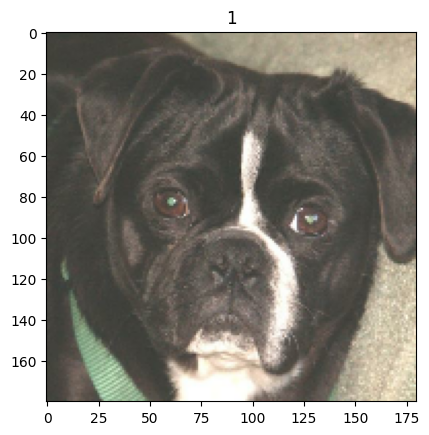

In [25]:
## selecting an image of the batch
# NOTE: This image must will used in future cells

import matplotlib.pyplot as plt

k = 10 # image of the batch (index in [0, BATCH_SIZE])
image = batch_x[k]
print(f"image.shape: {image.shape}")
label = batch_y[k]

plt.imshow(image.astype("uint8"))
plt.title(label)

In [26]:
image[0][0]

array([62.964813, 61.964813, 56.964813], dtype=float32)

## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
and label 0 is "cat".

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


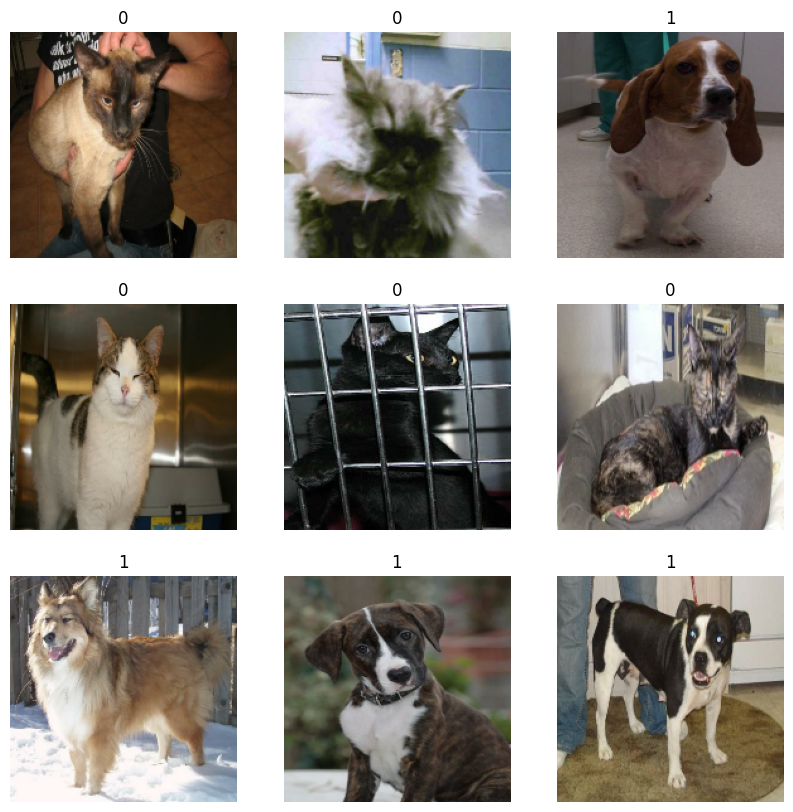

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # the first batch, which contains 128 (IMAGE, LABEL) objects
    for i in range(9): # only considering the first 9 elements of the batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [28]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

## RandomFlip

`documentation`: https://keras.io/api/layers/preprocessing_layers/image_preprocessing/random_flip/

In [29]:
modes = ["horizontal", "vertical", "horizontal_and_vertical"]

(-0.5, 179.5, 179.5, -0.5)

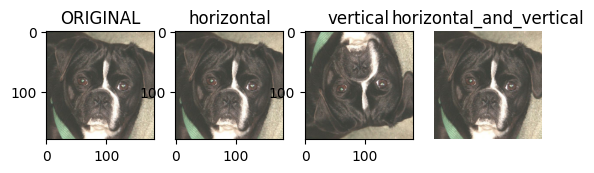

In [30]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(16, 16))
fig, axes = plt.subplots(1, len(modes) +1)

ax0 = axes.flat[0]
ax0.imshow(image.astype("uint8")) # reusing image extrated from batch (check above cells)
ax0.set_title("ORIGINAL")

for mode, ax in zip(modes, axes.flat[1:]): # only considering the first 9 elements of the batch
    random_flip = layers.RandomFlip(mode=mode)
    flipped_image = random_flip(image)

    ax.imshow(flipped_image.numpy().astype("uint8"))
    ax.set_title(mode)
plt.axis("off")

## RandomRotation

> **factor**: a float represented as fraction of 2pi, or a tuple of size 2 representing lower and upper bound for rotating clockwise and counter-clockwise. A positive values means rotating counter clock-wise, while a negative value means clock-wise. When represented as a single float, this value is used for both the upper and lower bound. For instance, factor=(-0.2, 0.3) results in an output rotation by a random amount in the range [-20% * 2pi, 30% * 2pi]. factor=0.2 results in an output rotating by a random amount in the range [-20% * 2pi, 20% * 2pi].


`documentation`: https://keras.io/api/layers/preprocessing_layers/image_preprocessing/random_rotation/

(-0.5, 179.5, 179.5, -0.5)

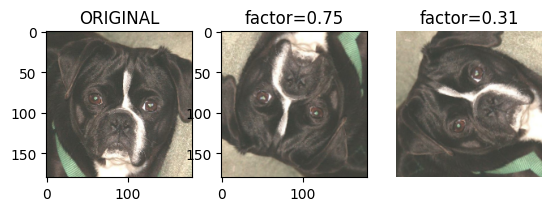

In [31]:
import matplotlib.pyplot as plt
import numpy as np

n = 2
fig, axes = plt.subplots(1, n+1)

ax0 = axes.flat[0]
ax0.imshow(image.astype("uint8")) # reusing image extrated from batch (check above cells)
ax0.set_title("ORIGINAL")

factors = np.random.rand(n)
for factor, ax in zip(factors, axes.flat[1:]): # only considering the first 9 elements of the batch
    random_rot = layers.RandomRotation(factor=factor)
    rotated_image = random_rot(image)

    ax.imshow(rotated_image.numpy().astype("uint8"))
    ax.set_title(f"factor={factor:.2}")
plt.axis("off")

Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first image in the dataset:

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


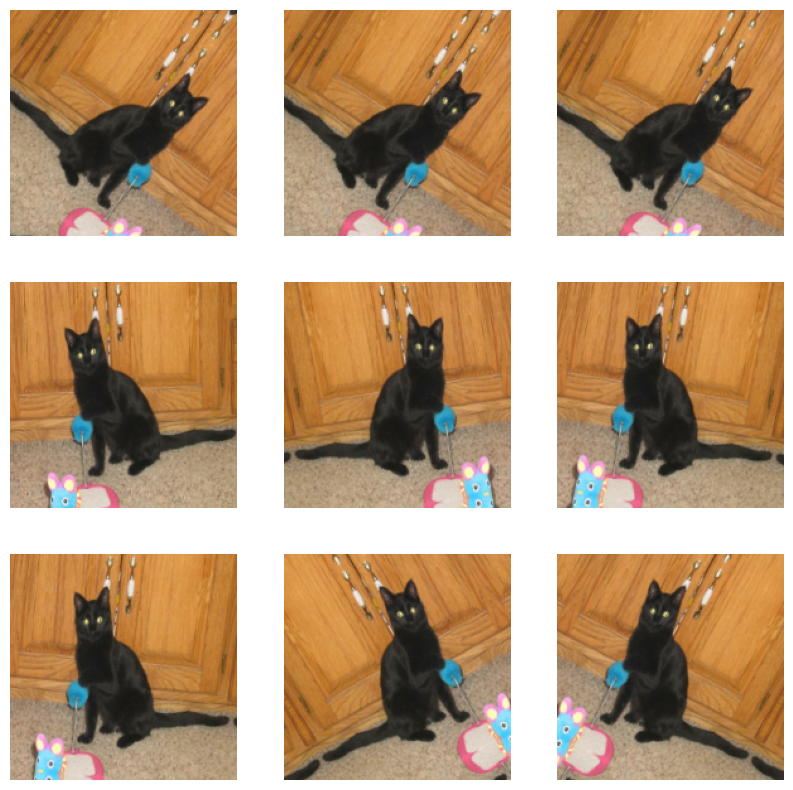

In [32]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1): # first batch
    for i in range(9):
        augmented_images = data_augmentation(images) # apply RandomFlip and RandomRotation on images of batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
augmented images, like this:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure
which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Configure the dataset for performance

Let's apply data augmentation to our training dataset,
and let's make sure to use buffered prefetching so we can yield data from disk without
having I/O becoming blocking:

In [33]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

In [34]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 180, 180, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 90, 90, 128)          3584      ['rescaling[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 90, 90, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                               

## Model Dissection

Detailed analysis of network layers.

### Input Layer

`documentation`: https://keras.io/api/layers/core_layers/input/

```txt
 Layer (type)                Output Shape                 Param #   Connected to                  
==================================================================================================
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []
```

The input layer, `keras.Input(shape=input_shape)`, ingest batches of data (with element shape equal to `input_shape`).

For example, in our case

In [35]:
inputs = train_ds.take(1) # only 1 batch for input
X, y = list(inputs.as_numpy_iterator())[0]

print(f"[Input Layer] input_shape: {X.shape[1:]}")
X.shape, y.shape

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


[Input Layer] input_shape: (180, 180, 3)


((128, 180, 180, 3), (128,))

### Rescaling Layer

`documentation`: https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/

In [36]:
# Initial values [0, 255] are scaled to [0, 1]
rescaling = layers.Rescaling(1.0 / 255) # tensor  <- tensor * 1.0/255

X = rescaling(X)
print(f"X.shape: {X.shape}")
X.numpy()[0]

X.shape: (128, 180, 180, 3)


array([[[0.7264404 , 0.20487176, 0.2872247 ],
        [0.72657114, 0.2050025 , 0.28735545],
        [0.7250963 , 0.20352757, 0.2858805 ],
        ...,
        [0.8230782 , 0.20061697, 0.27430835],
        [0.84419245, 0.22763829, 0.2825862 ],
        [0.8921235 , 0.3393182 , 0.38284913]],

       [[0.7302863 , 0.2087176 , 0.29107055],
        [0.7312201 , 0.20965154, 0.29200447],
        [0.7310704 , 0.20950174, 0.2918547 ],
        ...,
        [0.6572601 , 0.23802623, 0.31930897],
        [0.76430196, 0.25317496, 0.31794602],
        [0.8929338 , 0.30323896, 0.36576122]],

       [[0.7370394 , 0.21547072, 0.29782364],
        [0.74146646, 0.21989787, 0.30225077],
        [0.7438334 , 0.22226477, 0.3046177 ],
        ...,
        [0.3747805 , 0.2116419 , 0.273809  ],
        [0.5569747 , 0.23746249, 0.29118854],
        [0.7658545 , 0.2673409 , 0.3373376 ]],

       ...,

       [[0.4397477 , 0.29941055, 0.21603893],
        [0.45246348, 0.3060083 , 0.2195056 ],
        [0.4520787 , 0

In [37]:
# y NO NEED TO BE SCALED
y

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1], dtype=int32)

### Convolution

#### Definition


If $f$ is an integrable function defined on $R^n$ and $g$ is a bounded, locally
integrable function then the **convolution product** of $f$ and $g$ is the function on $R^n$ defined
by the integral.

$$f*g = \int_{R^n} f(x-y) g(y) dy$$

#### Resources
* [Intuitive Guide to Convolution](https://betterexplained.com/articles/intuitive-convolution/)
* [CS1114 Section 6: Convolution - Department of Computer Science](https://www.cs.cornell.edu/courses/cs1114/2013sp/sections/S06_convolution.pdf)
* [Convolution - University of Pennsylvania](https://www2.math.upenn.edu/~ccroke/chap5.pdf)

#### Convolution 1D


#### Convolution 2D


##### Interesting kernels

* Identity kernel
![conv2d-identity-kernel](./images/conv2d_identity_kernel.png)

* Mean kernel
![conv2d-mean-kernel](./images/conv2d_mean_kernel.png)

* Sharpening Kernel
![conv2d-sharpening-kernel](./images/conv2d_sharpening_kernel.png)

* *Sobel* convolution kernels (edge-detection):

![sobel-kernels](./images/sobel_kernels.png)

* *Laplacian* convolution kernels (edge-detection):

![laplacian-kernel](./images/laplacian_kernel.png)

### Conv2D Layer
`documentation`: https://keras.io/api/layers/convolution_layers/convolution2d/

> Input shape
>
> 4+D tensor with shape: batch_shape + (channels, rows, cols) if data_format='channels_first' or 4+D tensor with shape: batch_shape + (rows, cols, channels) if data_format='channels_last'.
>
> Output shape
>
> 4+D tensor with shape: batch_shape + (filters, new_rows, new_cols) if data_format='channels_first' or 4+D tensor with shape: batch_shape + (new_rows, new_cols, filters) if data_format='channels_last'. rows and cols values might have changed due to padding.
>
> Returns
>
> A tensor of rank 4+ representing activation(conv2d(inputs, kernel) + bias).

In [38]:
conv2d = layers.Conv2D(128, 3, strides=2, padding="same")

X = conv2d(X)

### BatchNormalization Layer

`documentation`: https://keras.io/api/layers/normalization_layers/batch_normalization/

> Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.


* Training
```txt
gamma * (batch - mean(batch)) / sqrt(var(batch) + epsilon) + beta
```

* Inference
```txt
gamma * (batch - self.moving_mean) / sqrt(self.moving_var+epsilon) + beta
```

#### Resources
- [Variance - Propagation](https://en.wikipedia.org/wiki/Variance#Propagation)
- [Moving mean - wikipedia](https://en.wikipedia.org/wiki/Moving_average#Simple_moving_average)
- [Moving Standard Deviation](https://www.zaner.com/3.0/education/technicalstudies/MSD.asp)

In [39]:
a, b, c = 2, 3, 4

n = a*b*c
X = np.arange(n).reshape(a, b, c)
print(X.shape)
X

(2, 3, 4)


array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [40]:
batchNormalization = layers.BatchNormalization()

In [41]:
XX = batchNormalization(X)
print(XX.shape)

XX

(2, 3, 4)


<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[ 0.       ,  0.9995004,  1.9990008,  2.9985013],
        [ 3.9980016,  4.997502 ,  5.9970026,  6.996503 ],
        [ 7.996003 ,  8.995503 ,  9.995004 , 10.994504 ]],

       [[11.994005 , 12.9935055, 13.993006 , 14.992506 ],
        [15.992006 , 16.991507 , 17.991007 , 18.990507 ],
        [19.990007 , 20.989508 , 21.989008 , 22.988508 ]]], dtype=float32)>

### SeparableConv2D Layer

????

### MaxPooling2D Layer

´documentation´: https://keras.io/api/layers/pooling_layers/max_pooling2d/

> Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

In [44]:
x = tf.constant([[1., 2., 3.],
                  [4., 5., 6.],
                  [7., 8., 9.]])

x = tf.reshape(x, [1, 3, 3, 1])
x

<tf.Tensor: shape=(1, 3, 3, 1), dtype=float32, numpy=
array([[[[1.],
         [2.],
         [3.]],

        [[4.],
         [5.],
         [6.]],

        [[7.],
         [8.],
         [9.]]]], dtype=float32)>

In [45]:
max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                           strides=(1, 1), padding='valid')

max_pool_2d(x)

<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[5.],
         [6.]],

        [[8.],
         [9.]]]], dtype=float32)>

### GlobalAveragePooling2D Layer

?????

In [46]:
input_shape = (2, 4, 5, 3)
elements = np.prod(input_shape)

elements

120

In [47]:
x = np.arange(elements).reshape(input_shape)
x

array([[[[  0,   1,   2],
         [  3,   4,   5],
         [  6,   7,   8],
         [  9,  10,  11],
         [ 12,  13,  14]],

        [[ 15,  16,  17],
         [ 18,  19,  20],
         [ 21,  22,  23],
         [ 24,  25,  26],
         [ 27,  28,  29]],

        [[ 30,  31,  32],
         [ 33,  34,  35],
         [ 36,  37,  38],
         [ 39,  40,  41],
         [ 42,  43,  44]],

        [[ 45,  46,  47],
         [ 48,  49,  50],
         [ 51,  52,  53],
         [ 54,  55,  56],
         [ 57,  58,  59]]],


       [[[ 60,  61,  62],
         [ 63,  64,  65],
         [ 66,  67,  68],
         [ 69,  70,  71],
         [ 72,  73,  74]],

        [[ 75,  76,  77],
         [ 78,  79,  80],
         [ 81,  82,  83],
         [ 84,  85,  86],
         [ 87,  88,  89]],

        [[ 90,  91,  92],
         [ 93,  94,  95],
         [ 96,  97,  98],
         [ 99, 100, 101],
         [102, 103, 104]],

        [[105, 106, 107],
         [108, 109, 110],
         [111, 112, 11

In [48]:
globalAveragePooling2D = tf.keras.layers.GlobalAveragePooling2D()

y = globalAveragePooling2D(x)

y

<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[28, 29, 30],
       [88, 89, 90]])>

### Dropout Layer

`documenatation`: https://keras.io/api/layers/regularization_layers/dropout/

> The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

In [89]:
tf.random.set_seed(0)
dropoutLayer = tf.keras.layers.Dropout(.2, input_shape=(2,))
data = np.arange(10).reshape(2, -1).astype(np.float32)

data

array([[0., 1., 2., 3., 4.],
       [5., 6., 7., 8., 9.]], dtype=float32)

In [90]:
np.sum(data)

45.0

In [91]:
outputs = dropoutLayer(data, training=True)

outputs

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[ 0.  ,  1.25,  2.5 ,  3.75,  5.  ],
       [ 6.25,  7.5 ,  8.75, 10.  ,  0.  ]], dtype=float32)>

In [92]:
np.sum(outputs)

45.0

### Dense Layer

´documentation´: https://keras.io/api/layers/core_layers/dense/


> Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer

### Activation Layers

Function that transforms the weighted sum of a neuron so that the output is non-linear.

#### Resources
- [Activation Functions in Neural Networks](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)

#### Softmax and Sigmoid Activation Layer

**Diferences**

> Sigmoid is used for binary classification methods where we only have 2 classes, while SoftMax applies to multiclass problems. In fact, the SoftMax function is an extension of the Sigmoid function.

![softmax_and_sigmoid_differences](./images/softmax_and_sigmoid_differences.png)

**Equations**

![sigmod-activation-function](./images/sigmoid_activation_function.png)

![softmax-activation-function](./images/sofmax_activation_function.png)

**Graphic**

![sigmod-activation-function-graphic](./images/sigmoid_activation_function_graphic.png)

##### Resources
- [Sigmoid and SoftMax Functions in 5 minutes](https://towardsdatascience.com/sigmoid-and-softmax-functions-in-5-minutes-f516c80ea1f9)

In [82]:
#### softmax

from math import exp


x = np.asarray([[1., 2., -1.]]) # input to softmax activation layer

softmaxLayer = tf.keras.layers.Softmax()

y = softmaxLayer(x).numpy()
print(f"y = {y}")

y = [[0.25949648 0.70538455 0.03511903]]


In [81]:
# y0 = exp(x0) / sum_{i = 1-n} exp(xi)
y0 = exp(x[0][0]) / sum(np.exp(x[0]))

0.21194155761708544

In [85]:
# the sum  of all the components of the output of a sofmax function is 1
np.sum(y)

1.0000001

#### Relu Activation Layer

`documentation`: https://keras.io/api/layers/activation_layers/relu/

![relu-activation-function](./images/relu_activation_function.png)

```txt
# relu function in simple terms

if input > 0:
 return input
else:
 return 0
```


##### Resources
- [A Gentle Introduction to the Rectified Linear Unit (ReLU)](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)

In [88]:
#### Relu

x = [-3.0, -1.0, 0.0, 2.0] # input for relu activation function

reluLayer = tf.keras.layers.ReLU()
y = reluLayer(x).numpy()

y

array([0., 0., 0., 2.], dtype=float32)

## Train the model

In [53]:
epochs = 3 # 25

checkpoint_filepath = './checkpoints/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_binary_crossentropy',
    mode='max',
    save_best_only=True)

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    model_checkpoint_callback,
    tf.keras.callbacks.ProgbarLogger(count_mode="steps"),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=10**-3)
]

metrics = [
    #tf.keras.metrics.Accuracy(),
    tf.keras.metrics.BinaryCrossentropy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.AUC(),
    #tf.keras.metrics.Recall()
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics
)

### Optimizer

#### Resources
- [Gentle Introduction to the Adam Optimization Algorithm for Deep Learning](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning)
- [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)
- [An overview of gradient descent optimization algorithms](https://arxiv.org/abs/1609.04747)

---
- [Gradient Descent Algorithm — a deep dive](https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21)
- [Neural Networks Backpropagation Made Easy](https://towardsdatascience.com/neural-networks-backpropagation-by-dr-lihi-gur-arie-27be67d8fdce)


### Loss function


> The loss function is the function that computes the distance between the current output of the
 algorithm and the expected output. It’s a method to evaluate how your algorithm models the data.

#### Resources
- [What are Loss Functions?](https://towardsdatascience.com/what-is-loss-function-1e2605aeb904)


In [54]:
subtrain_ds = train_ds.take(5) # use only a few batches to train the model (WITH COMPLETE DATA IT TAKE A WHILE)
subval_ds = val_ds.take(2)

"""
model.fit(
    subtrain_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=subval_ds,
)
"""

'\nmodel.fit(\n    subtrain_ds,\n    epochs=epochs,\n    callbacks=callbacks,\n    validation_data=subval_ds,\n)\n'

We get to >90% validation accuracy after training for 25 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).

## Disecting training process


### binary_crossentropy loss function

### Adam optimizer

## Loading the model for measurements

In [55]:
# create and "empty" (no weights) model
saved_model = make_model(input_shape=image_size + (3,), num_classes=2)

In [56]:
checkpoint_filepath = './checkpoints/'

# load weights (computed on training)
print(f"checkpoint_filepath: {checkpoint_filepath}")
saved_model.load_weights(checkpoint_filepath)

checkpoint_filepath: ./checkpoints/


In [57]:
#model = saved_model

### Metrics

In [58]:
train_batch = subtrain_ds.take(1)

X_train, y_train = list(train_batch.as_numpy_iterator())[0]

X_train.shape, y_train.shape

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


((128, 180, 180, 3), (128,))

In [59]:
# sample batch to compute metrics

val_batch = val_ds.take(1)
X_val, y_val = list(val_batch.as_numpy_iterator())[0]

X_val.shape, y_val.shape

((128, 180, 180, 3), (128,))

In [60]:
model.evaluate(X_val, y_val)

4/4 [==============================] - 5s 1s/step - loss: 0.6932 - binary_crossentropy: 0.6932 - precision: 0.4844 - auc: 0.5000


[0.6931633353233337, 0.6931633353233337, 0.484375, 0.5]

#### Accuracy
`documentation`: https://keras.io/api/metrics/accuracy_metrics/#accuracy-class

The accuracy is the proportion of **correct predictions** among the **total number of cases examined**.

![accuracy-equation](./images/accuracy_equation.png)


##### References
* [Accuracy and precision](https://en.wikipedia.org/wiki/Accuracy_and_precision)

In [61]:
y_pred_val = model.predict(X_val)
y_pred_val # umbral = 0.5

4/4 [==============================] - 4s 992ms/step


array([[0.5010101 ],
       [0.50104815],
       [0.500998  ],
       [0.5008182 ],
       [0.50081015],
       [0.5006804 ],
       [0.5011834 ],
       [0.50074166],
       [0.5007404 ],
       [0.50081354],
       [0.50090325],
       [0.5010469 ],
       [0.50089025],
       [0.50114435],
       [0.5012996 ],
       [0.5008577 ],
       [0.5008057 ],
       [0.5008323 ],
       [0.5011181 ],
       [0.50097436],
       [0.50076926],
       [0.5007199 ],
       [0.5009486 ],
       [0.5006836 ],
       [0.5011117 ],
       [0.5006948 ],
       [0.50054705],
       [0.500792  ],
       [0.5007791 ],
       [0.5008626 ],
       [0.5004894 ],
       [0.5009531 ],
       [0.501121  ],
       [0.50102246],
       [0.5006475 ],
       [0.5010271 ],
       [0.5009994 ],
       [0.5007645 ],
       [0.5006666 ],
       [0.50093496],
       [0.50070775],
       [0.50097233],
       [0.50054806],
       [0.50107336],
       [0.500813  ],
       [0.5003847 ],
       [0.5008962 ],
       [0.500

In [62]:
y_val

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0], dtype=int32)

In [63]:
y_pred_train = model.predict(X_train)
y_pred_train

4/4 [==============================] - 4s 1s/step


array([[0.50084037],
       [0.5005762 ],
       [0.5007273 ],
       [0.5006464 ],
       [0.5006757 ],
       [0.50093377],
       [0.5008418 ],
       [0.5007369 ],
       [0.5009577 ],
       [0.50042623],
       [0.50101715],
       [0.5003261 ],
       [0.5007173 ],
       [0.50065726],
       [0.500969  ],
       [0.50104   ],
       [0.5007369 ],
       [0.5012    ],
       [0.500922  ],
       [0.50083464],
       [0.5008955 ],
       [0.50124776],
       [0.5009004 ],
       [0.500924  ],
       [0.5009103 ],
       [0.5005649 ],
       [0.50065565],
       [0.5007929 ],
       [0.5003925 ],
       [0.50094664],
       [0.50099015],
       [0.50117445],
       [0.50085986],
       [0.5006149 ],
       [0.5010956 ],
       [0.5008106 ],
       [0.5010555 ],
       [0.5007819 ],
       [0.50089765],
       [0.50109494],
       [0.5008229 ],
       [0.50074434],
       [0.50099313],
       [0.5007704 ],
       [0.50065005],
       [0.5011595 ],
       [0.5012868 ],
       [0.500

In [64]:
y_train

array([0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1], dtype=int32)

In [65]:
model.evaluate(X_train, y_train)

4/4 [==============================] - 4s 992ms/step - loss: 0.6930 - binary_crossentropy: 0.6930 - precision: 0.5547 - auc: 0.5000


[0.6929599046707153, 0.6929599046707153, 0.5546875, 0.5]

#### Precision

`documentation`: https://keras.io/api/metrics/classification_metrics/#precision-class

> The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the **ability of the classifier not to label as positive a sample that is negative**.
> The best value is 1 and the worst value is 0.

##### References
* [sklearn.metrics.precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)

In [66]:
##

#### Accuracy vs Precision

**Accuracy** is how close a given set of measurements are to their true value, while **precision** is how close the measurements are to each other.

![accuracy-and-precision](./images/accuracy_and_precision.png)

#### AUC
`documentation`: https://keras.io/api/metrics/classification_metrics/#auc-class

#### Confusion Matrix

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

In [67]:
img = keras.utils.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)

type(img)
image = keras.utils.img_to_array(img)
image

array([[[249., 254., 247.],
        [249., 255., 251.],
        [252., 253., 255.],
        ...,
        [251., 253., 250.],
        [253., 253., 251.],
        [253., 253., 251.]],

       [[253., 252., 250.],
        [252., 254., 251.],
        [249., 255., 253.],
        ...,
        [252., 252., 250.],
        [254., 254., 252.],
        [254., 254., 252.]],

       [[253., 251., 252.],
        [253., 253., 251.],
        [249., 255., 251.],
        ...,
        [253., 253., 251.],
        [254., 254., 252.],
        [254., 254., 252.]],

       ...,

       [[252., 254., 251.],
        [253., 253., 251.],
        [253., 253., 251.],
        ...,
        [253., 253., 251.],
        [254., 254., 252.],
        [254., 254., 252.]],

       [[252., 254., 249.],
        [253., 254., 249.],
        [253., 253., 251.],
        ...,
        [253., 253., 251.],
        [254., 254., 252.],
        [254., 254., 252.]],

       [[252., 254., 249.],
        [253., 254., 249.],
        [253., 2

image.shape: (180, 180, 3)
type(image): <class 'numpy.ndarray'>


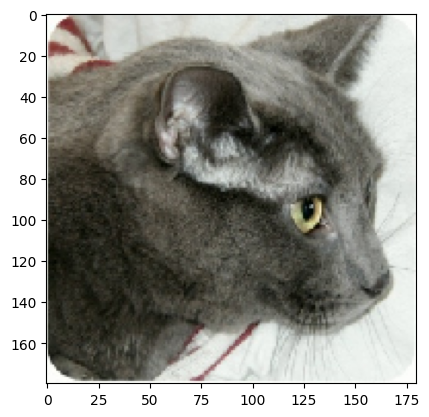

In [68]:
img = keras.utils.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)

image = keras.utils.img_to_array(img)
image *= 1.0/255
print(f"image.shape: {image.shape}")
print(f"type(image): {type(image)}")

plt.imshow(image)

In [69]:
image_batch  = tf.expand_dims(image, 0)  # Create batch axis
print(f"type(image_batch): {type(image_batch)}")
print(f"image_batch.shape: {image_batch.shape}")

type(image_batch): <class 'tensorflow.python.framework.ops.EagerTensor'>
image_batch.shape: (1, 180, 180, 3)


In [70]:
predictions = model.predict(image_batch)
# probability to be dog
predictions

1/1 [==============================] - 0s 217ms/step


array([[0.50000364]], dtype=float32)

## Images with noise

noise.shape: (180, 180, 3)


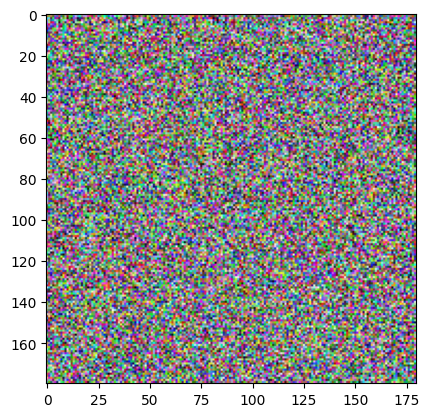

In [71]:
noise = np.random.rand(*image_size, 3)

print(f"noise.shape: {noise.shape}")

plt.imshow(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


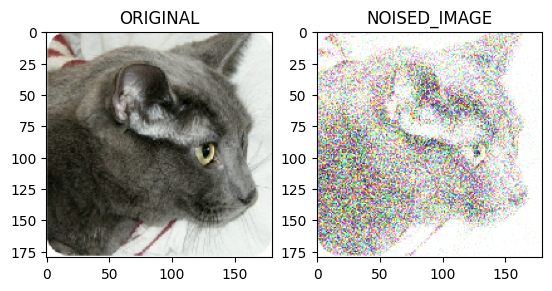

In [72]:
noised_image = image + noise

images = [('ORIGINAL', image), ('NOISED_IMAGE', noised_image)]

fig, axes = plt.subplots(1, 2)

for (label, img_array), ax in zip(images, axes.flat):
    ax.imshow(img_array)
    ax.set_title(label)


In [73]:
noised_image_batch  = tf.expand_dims(noised_image, 0)  # Create batch axis
print(f"noised_image_batch.shape: {noised_image_batch.shape}")

noised_image_batch.shape: (1, 180, 180, 3)


In [74]:
predictions = model.predict(noised_image_batch)
# probability to be dog
predictions

1/1 [==============================] - 0s 197ms/step


array([[0.50000733]], dtype=float32)